# Atividade 3 - Análise de componentes principais (PCA)

Nesta atividade iremos analisar a nossa base de dados utilizando a técnica de Análise de Componentes Principais com a finalidade de entender como os dados da nossa base se comportam e como podemos aplicar uma técnica de redução dimensional nela.

## Relembrando o nosso dataset

Para o nosso trabalhos, estamos utilizando o dataset [Grammatical Facial Expressions](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions), que descreve expressões faciais gramaticais da linguagem brasileira de sinais (Libras).

A base possui `27965 instâncias`, subdivididas em 9 expressões: `Interrogativa (qu)`,`Interrogativa (s/n)`, `Interrogativa (dúvida)`, `Negativa`, `Afirmativa`, `Condicional`, `Relativa`, `Tópico` e `Foco`. 

Cada instância é estruturada em `300 características`, que representam 100 pontos com coordenadas (x, y, z) da face. Não há missing values nesses pontos e eles já passaram por um processo de normalização previamente, onde sofreram uma translação para uma base em comum, como pode ser visto na página 65 de [Freitas, 2015](https://teses.usp.br/teses/disponiveis/100/100131/tde-10072015-100311/pt-br.php). 

A classificação de instância é binária onde ela pode ser positiva (os pontos representam a expressão facial) ou negativa (a expressão é neutra).

Visualizando todas as instâncias da base, podemos identificar a quantidade de instâncias por expressão e classe na tabela abaixo:

In [1]:
from _database import all_categories_database_instance_description
all_categories_database_instance_description()

,Facial Expression,Positive Instances,Positive Instance Proportion,Negative Instances,Negative Instance Proportion,Total Instances
0,wh_question,1158,0.442999,1456,0.557001,2614
1,yn_question,1247,0.398657,1881,0.601343,3128
2,doubt_question,1271,0.452474,1538,0.547526,2809
3,negative,1240,0.458241,1466,0.541759,2706
4,affirmative,942,0.441011,1194,0.558989,2136
5,conditional,1137,0.288505,2804,0.711495,3941
6,relative,1194,0.282003,3040,0.717997,4234
7,topics,827,0.228390,2794,0.771610,3621
8,emphasis,861,0.313433,1886,0.686567,2747


Observando a proporção de classes em relação ao total de instâncias, podemos perceber que as expressões com bases mais próximas de balanceadas (i.e., tem proporção de classes positivas e negativas parecidas) são: `wh_question`, `doubt_question`, `negative` e `affirmative`.

Nesta atividade iremos aplicar o PCA em todas as expressões para entender melhor o comportamento da técnica em cada expressão facial. Em atividades futuras devemos focar as análises somente em uma das expressões.

## Análise de componentes principais (PCA, Principal Component Analysis)

Na análise de componentes principais buscamos converter as variáveis de um conjunto de dados, possivelmente correlacionadas, através de uma transformação ortogonal em novas variáveis não correlacionadas sob uma nova base de coordenadas, os componentes principais, de forma que os primeiros componentes representem grande parte da variância do conjunto de dados inicial.

Neste estudo utilizaremos a biblioteca [sklearn](https://scikit-learn.org/stable/) do Python que já possui a técnica PCA [previamente implementada](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

Iremos aplica-la nos dados 2 vezes: 
- uma com os dados brutos, simulando o PCA utilizando a matriz de covariância dos dados;
- outra com os dados normalizados, simulando o PCA utilizando a matriz de correlação dos dados.

E para efeito de redução de dimensões, iremos considerar todos os componentes que representem até 80% da variância dos dados originais.

Na implementação buscamos aplicar o PCA no conjunto de dados de forma a obter a base transformada, os componentes principais e as estatísticas da técnica:

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd

# maxima variância esperada
PCA_THRESHOLD = 80.0

def principal_component_analysis(features, X):
    """Calcula o PCA com o sklearn"""
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    component_names = list(map(lambda i : f'PC{i}', range(1, len(features) + 1)))
    
    # como o PCA do sklearn utiliza SVD, ao invés de ele nos retornar os autovalores (eigenvalues),
    # ele nos retorna valores singulares (singular values), que precisam ser convertidos para autovalores
    # referência: https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
    eigenvalues = pd.Series(data=(pca.singular_values_ ** 2) / (len(X)), index=component_names)
    variance_ratio = pd.Series(data=pca.explained_variance_ratio_ * 100, index=component_names)
    
    pca_stats = pd.DataFrame(data={
        'Eigenvalues': eigenvalues,
        'Variance %': variance_ratio,
        'Cum. Eigenvalues': eigenvalues.cumsum(),
        'Cum. Variance %': variance_ratio.cumsum()
    })

    principal_components = pd.DataFrame(data=pca.components_.T, columns=component_names, index=features)
    
    # encontra o PC que faz ultrapassa o limiar 
    threshold_expression = pca_stats['Cum. Variance %'] >= PCA_THRESHOLD
    threshold_index = pca_stats[threshold_expression].head(1).index.values

    # mostra todos os pcs dentro do limiar mais o primeiro que passou o limiar
    principal_components_under_threshold = list(pca_stats[~threshold_expression].index.values) + list(threshold_index)
    
    return pca_stats, principal_components, principal_components_under_threshold, X_transformed

### Aplicando o PCA para uma expressão

explicação sobre a aplicação

In [3]:
from _database import load_datapoints, load_targets

category = 'negative'
data = load_datapoints(category)
targets = load_targets(category)

features = list(data.columns)

# PCA com dados brutos (equivalente ao cálculo com matriz de covariância)
X = data.values
pca_stats, principal_components, principal_components_under_threshold, X_transformed = principal_component_analysis(features, X)

# PCA com dados normalizados (equivalente ao cálculo com matriz de correlação)
normalized_X = StandardScaler().fit_transform(X)
normalized_pca_stats, normalized_principal_components, normalized_principal_components_under_threshold, normalized_X_transformed = principal_component_analysis(features, normalized_X)

In [4]:
pca_stats[pca_stats.index.isin(principal_components_under_threshold)]

,Eigenvalues,Variance %,Cum. Eigenvalues,Cum. Variance %
PC1,2.366309e+06,32.230159,2.366309e+06,32.230159
PC2,6.872079e+05,9.360071,3.053517e+06,41.590230
PC3,5.684479e+05,7.742508,3.621965e+06,49.332738
PC4,3.920549e+05,5.339958,4.014020e+06,54.672695
PC5,2.982401e+05,4.062160,4.312260e+06,58.734855
PC6,2.852202e+05,3.884823,4.597480e+06,62.619679
PC7,2.458860e+05,3.349074,4.843366e+06,65.968753
PC8,1.966818e+05,2.678891,5.040048e+06,68.647644
PC9,1.955887e+05,2.664003,5.235636e+06,71.311647
PC10,1.745645e+05,2.377645,5.410201e+06,73.689292


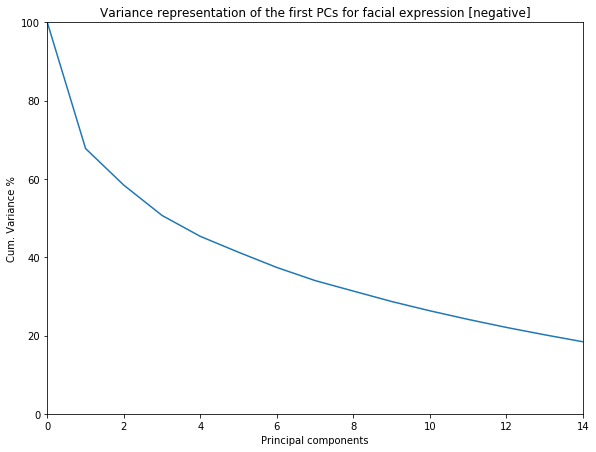

In [5]:
import matplotlib.pyplot as plt

threshold_stats = pca_stats[pca_stats.index.isin(principal_components_under_threshold)]
plot_y = [ 100.0 ] + list(100.0 - threshold_stats['Cum. Variance %'].values)
plot_x = list(range(0, len(plot_y)))

plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
plt.axis([0, len(plot_y) - 1, 0, 100])
plt.ylabel('Cum. Variance %')
plt.xlabel('Principal components')
plt.title(f'Variance representation of the first PCs for facial expression [{category}]')
plt.plot(plot_x, plot_y)
plt.show()

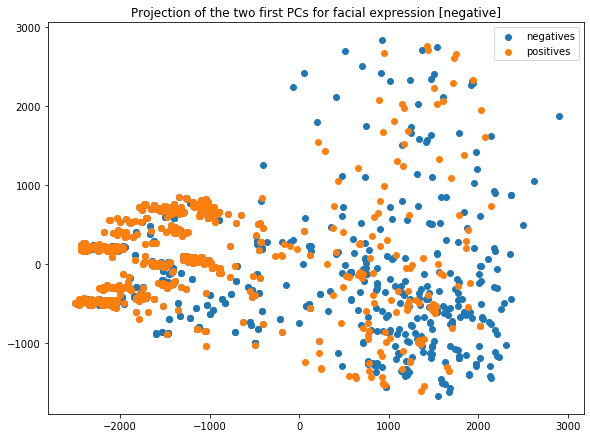

In [6]:
reduced_X = X_transformed[:, 0:len(principal_components_under_threshold)]

negatives = reduced_X[targets[targets['target'] == 0].index.values, :]
positives = reduced_X[targets[targets['target'] == 1].index.values, :]

plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
plt.scatter(negatives[:, 0], negatives[:, 1], c = '#1f77b4')
plt.scatter(positives[:, 0], positives[:, 1], c = '#ff7f0e')
plt.legend(['negatives', 'positives'])
plt.title(f'Projection of the two first PCs for facial expression [{category}]')
plt.show()

In [7]:
normalized_pca_stats[normalized_pca_stats.index.isin(normalized_principal_components_under_threshold)]

,Eigenvalues,Variance %,Cum. Eigenvalues,Cum. Variance %
PC1,197.016257,65.672086,197.016257,65.672086
PC2,23.985747,7.995249,221.002004,73.667335
PC3,12.240866,4.080289,233.242870,77.747623
PC4,4.626893,1.542298,237.869763,79.289921
PC5,2.620769,0.873590,240.490532,80.163511


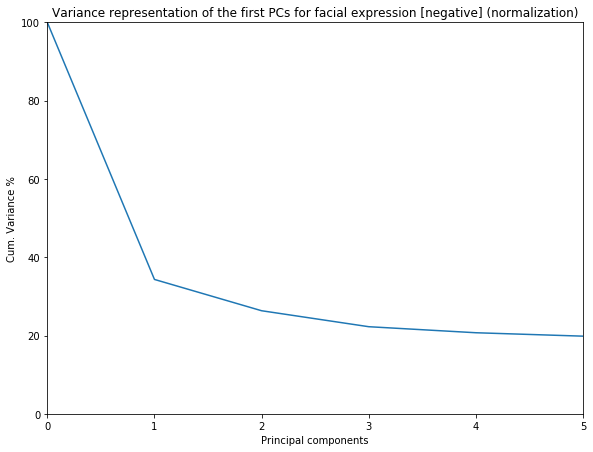

In [8]:
import matplotlib.pyplot as plt

normalized_threshold_stats = normalized_pca_stats[normalized_pca_stats.index.isin(normalized_principal_components_under_threshold)]
plot_y = [ 100.0 ] + list(100.0 - normalized_threshold_stats['Cum. Variance %'].values)
plot_x = list(range(0, len(plot_y)))

plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
plt.axis([0, len(plot_y) - 1, 0, 100])
plt.ylabel('Cum. Variance %')
plt.xlabel('Principal components')
plt.title(f'Variance representation of the first PCs for facial expression [{category}] (normalization)')
plt.plot(plot_x, plot_y)
plt.show()

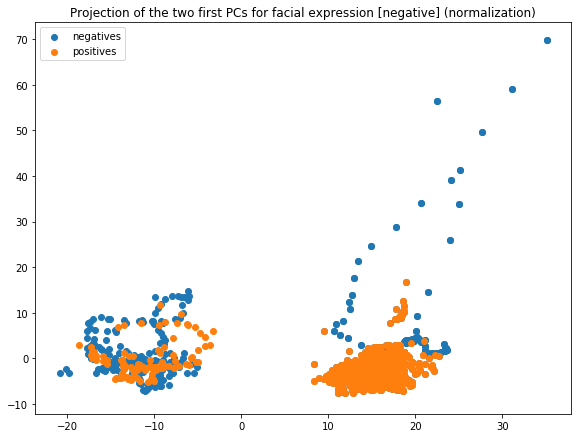

In [9]:
reduced_X = normalized_X_transformed[:, 0:len(normalized_principal_components_under_threshold)]

negatives = reduced_X[targets[targets['target'] == 0].index.values, :]
positives = reduced_X[targets[targets['target'] == 1].index.values, :]

plt.figure(figsize=[6.4 * 1.5, 4.8 * 1.5])
plt.scatter(negatives[:, 0], negatives[:, 1], c = '#1f77b4')
plt.scatter(positives[:, 0], positives[:, 1], c = '#ff7f0e')
plt.legend(['negatives', 'positives'])
plt.title(f'Projection of the two first PCs for facial expression [{category}] (normalization)')
plt.show()